## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import cmdstanpy 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import os
import json

from scipy.stats import gaussian_kde
import ipywidgets as widgets

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

## Choose Model

#### roots

In [3]:
root = './'
plots_root = root + 'Plots/'
datasets_root = root + 'Datasets/'
behavioural_data_root = root +  'behavioral_data/selected_data/' 
stan_files_root = root +  'stan files/' 
saved_models_root = root + 'stan_results/'

model_config = {}
plots_path = ''
dataset_path = ''
stan_file_path = ''
stan_output_dir = ''

#### read models configuration json file

In [4]:
with open("lba_models.json") as f:
    models = json.load(f)
    models_name = list(models.keys())

#### Choose and set model configuration

In [5]:
def SetModelAndPaths(model_name):
    global model_config
    global plots_path
    global dataset_path
    global stan_file_path
    global stan_output_dir
    model_config = models[model_name]
    plots_path = plots_root + model_config['plots_folder_name'] + '/'
    dataset_path = datasets_root + model_config['dataset_name']
    stan_file_path = stan_files_root + model_config['stan_file']
    stan_output_dir = saved_models_root + model_config['model_name'] + '/'
    os.path
    
    if not os.path.exists(plots_path):
        os.makedirs(plots_path)
        print("Directory " , plots_path ,  " Created ")
    else:    
        print("Directory " , plots_path ,  " already exists")
        
    if not os.path.exists(stan_output_dir):
        os.makedirs(stan_output_dir)
        print("Directory " , stan_output_dir ,  " Created ")
    else:    
        print("Directory " , stan_output_dir ,  " already exists")

widgets.interact(SetModelAndPaths, model_name=models_name);

interactive(children=(Dropdown(description='model_name', options=('LBA_cd', 'LBA_ndm', 'ANN-LBA_l_FC', 'ANN-LB…

In [13]:
model_config

{'model_name': 'ANN-LBA_full_s_BERT',
 'stan_file': 'ANN-LBA/sigmoid_am_ndm.stan',
 'dataset_name': 'BERT.csv',
 'plots_folder_name': 'ANN-LBA_full_s_BERT',
 'transf_params': ['transf_mu_k_word',
  'transf_mu_k_nonword',
  'transf_mu_sp_trial_var_word',
  'transf_mu_sp_trial_var_nonword',
  'transf_mu_g',
  'transf_mu_m',
  'transf_mu_alpha',
  'transf_mu_b',
  'transf_mu_theta_1',
  'transf_mu_theta_2',
  'transf_mu_drift_variability']}

## Prepare data

Loading words and non-words with zipf and predicted probabilities

In [7]:
word_nword_df = pd.read_csv(dataset_path, header=None,
                            names =['string', 'freq',  'label', 'zipf',
                                    'category', 'word_prob', 'non_word_prob'])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,yumps,0,0,0.000000,NW,0.001433,0.998567
1,boxcars,89,1,2.246077,LF,0.994324,0.005676
2,creedam,0,0,0.000000,NW,0.004419,0.995581
3,granike's,0,0,0.000000,NW,0.000569,0.999431
4,repomses,0,0,0.000000,NW,0.005357,0.994643
...,...,...,...,...,...,...,...
74312,farmhouse,234,1,3.124343,HF,0.999835,0.000165
74313,elwrap,0,0,0.000000,NW,0.015441,0.984560
74314,plazing,0,0,0.000000,NW,0.028408,0.971592
74315,sirths,0,0,0.000000,NW,0.001985,0.998015


In [8]:
# Reading LDT Data
behavioural_df = pd.read_csv(behavioural_data_root + 'LDT_data_test.csv', header=None,
                             names=['accuracy', 'rt', 'string', 'response',
                                    'participant', 'minRT', 'participant_id'])
# Merging  behavioral dataframe with word_nonword_df to have words and non-words data with behavioral data
behavioural_df = pd.merge(behavioural_df, word_nword_df, on='string', how='left').dropna().reset_index(drop=True)
behavioural_df = behavioural_df.drop(['freq', 'participant'], axis=1)

In [9]:
behavioural_df.head()

,accuracy,rt,string,response,minRT,participant_id,label,zipf,category,word_prob,non_word_prob
0,1,0.502,stunt,1,0.362,1,1.0,3.963932,HF,0.999970,0.000030
1,1,0.577,elastic,1,0.362,1,1.0,3.024228,HF,0.999893,0.000107
2,1,0.518,now,1,0.362,1,1.0,6.504911,HF,0.999730,0.000270
3,0,0.543,vaitresses,1,0.362,1,0.0,0.000000,NW,0.044072,0.955928
4,1,0.556,sweetness,1,0.362,1,1.0,3.517143,HF,0.997965,0.002035


Predicted probabilities of words and non-words in different conditions in all trials
across participants

In [10]:
behavioural_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'],
                                          'non_word_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                     non_word_prob  \
              mean       std count       max       min          mean   
category                                                               
HF        0.965063  0.115770   359  1.000000  0.073869      0.034937   
LF        0.834971  0.238982   488  1.000000  0.006154      0.165029   
NW        0.086334  0.159452   994  0.999154  0.000014      0.913666   

                                                  
               std count       max           min  
category                                          
HF        0.115770   359  0.926131  2.411551e-07  
LF        0.238982   488  0.993846  3.725484e-07  
NW        0.159452   994  0.999986  8.463810e-04

RT and response description of words and non-words in different conditions in all trials
across participants

In [11]:
behavioural_df.groupby(['category']).agg({'rt': ['mean', 'std', 'max', 'min'],
                                          'response': ['mean', 'std', 'max', 'min']})

rt                          response                  
              mean       std    max    min      mean       std max min
category                                                              
HF        0.706532  0.259814  2.003  0.216  0.949861  0.218537   1   0
LF        0.855375  0.300717  2.165  0.200  0.807377  0.394764   1   0
NW        0.882127  0.311168  2.226  0.203  0.135815  0.342764   1   0

## Stan Model and Estimation

Compiling stan model

In [13]:
lba_model = cmdstanpy.CmdStanModel(model_name=model_config['model_name'],
                                   stan_file=stan_file_path);

18:26:12 - cmdstanpy - INFO - compiling stan file E:\Workspace\Thesis\ANN-EAM\stan files\ANN-LBA\sigmoid_am_ndm.stan to exe file E:\Workspace\Thesis\ANN-EAM\stan files\ANN-LBA\sigmoid_am_ndm.exe
18:26:46 - cmdstanpy - INFO - compiled model executable: E:\Workspace\Thesis\ANN-EAM\stan files\ANN-LBA\sigmoid_am_ndm.exe
18:26:46 - cmdstanpy - WARNING - Stan compiler has produced 34 warnings:
18:26:46 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/Arash/AppData/Local/Temp/tmpnt8a_iz5/tmpw4utlwwg.hpp C:/Users/Arash/AppData/Local/Temp/tmpnt8a_iz5/tmpw4utlwwg.stan
Warning in 'C:/Users/Arash/AppData/Local/Temp/tmpnt8a_iz5/tmpw4utlwwg.stan', line 109, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/Users/Arash/AppData/Local/Tem

Preparing model's inputs

note that some inputs of data_dict might not be used depending on which model is used

In [14]:
N = len(behavioural_df)                                                    # For all models
participant = behavioural_df['participant_id'].to_numpy()                     # For all models
p = behavioural_df.loc[:, ['word_prob', 'non_word_prob']].to_numpy()       # predicted probabilites of words and non-words, for ANN-EAM models
frequency = behavioural_df['zipf'].to_numpy().astype(int)                  # zipf values For models with non-decision time or drift modulation
frequencyCondition = behavioural_df['category'].replace(["HF", "LF", "NW"], [1, 2, 3]).to_numpy() # For models with conditional drift
response = behavioural_df['response'].to_numpy().astype(int)               # for all models
rt = behavioural_df['rt'].to_numpy()                                       # for all models
minRT = behavioural_df['minRT'].to_numpy()                                 # for all models
RTbound = 0.1                                                              # for all models
Number_Of_Participants = len(set(behavioural_df['participant_id']))

k_priors = [0, 1, 1, 1]                  # All models with LBA
A_priors = [1, 2, 1, 1]                  # All models wtih LBA
ndt_priors = [0, 1, 1, 1];               # For models wtihout non-decision time modulation
g_priors = [-2, 1, 0, 1]                 # For models wtih non-decision time modulation
m_priors = [0, 0.5, 0, 1]                # For models wtih non-decision time modulation
drift_priors = [1, 2, 1, 1]              # For models withoud drift mapping functions (non ANN-EAM models)
alpha_priors = [0, 1, 1, 1]              # For models with drift mapping functions
b_priors = [0, 1, 1, 1]                  # For models with drift mapping functions with asymptote modulation and linear models
# There is a k parameter in LBA impelemention so we use theta as k parameter in sigmoid function
theta_priors = [2, 1, 1, 1]              # For models with sigmoid drift mapping functions (ANN-EAM models) (equivalent of k_priors in RDM and ANN-RDM)
sp_trial_var_priors = [1, 1, 0, 1]
drift_variability_priors = [1, 1, 1, 1]

# define input for the model
data_dict = {'N': N,
             'L': Number_Of_Participants,
             'participant': participant,
             'response': response,
             'rt': rt,
             'minRT': minRT,
             'RTbound': RTbound,
             'frequency': frequency,
             'frequencyCondition': frequencyCondition,
             'k_priors': k_priors,
             'A_priors': A_priors,
             'ndt_priors': ndt_priors,
             'g_priors': g_priors,
             'm_priors': m_priors,
             'drift_priors': drift_priors,
             'p': p,
             'alpha_priors': alpha_priors,
             'b_priors': b_priors,
             'k_priors': k_priors,
             'theta_priors': theta_priors,
             'sp_trial_var_priors': sp_trial_var_priors,
             'drift_variability_priors': drift_variability_priors
             }

# set sampling parameters
n_iter = 500
n_warmup = int(n_iter/2)
n_sample = int(n_iter/2)
n_chains = 2

Fitting the model

In [15]:
fit = lba_model.sample(data=data_dict,
                       iter_sampling=n_sample, 
                       iter_warmup=n_warmup,
                       chains=n_chains,
                       output_dir=stan_output_dir,
                       show_console=True)

18:26:52 - cmdstanpy - INFO - Chain [1] start processing
18:26:52 - cmdstanpy - INFO - Chain [2] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 250
Chain [1] num_warmup = 250
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = C:\Users\Arash\AppData\Local\Temp\tmpxg3tu8is\84p31lkw.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed = 35822
Chain [1] outp

19:03:22 - cmdstanpy - INFO - Chain [2] done processing


Chain [2] 
Chain [2] Elapsed Time: 1169.9 seconds (Warm-up)
Chain [2] 1020.27 seconds (Sampling)
Chain [2] 2190.18 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 


19:06:03 - cmdstanpy - INFO - Chain [1] done processing
19:06:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: Exception: Phi: x is nan, but must be not nan! (in 'C:/Users/Arash/AppData/Local/Temp/tmpnt8a_iz5/tmpw4utlwwg.stan', line 25, column 8 to column 34) (in 'C:/Users/Arash/AppData/Local/Temp/tmpnt8a_iz5/tmpw4utlwwg.stan', line 83, column 20 to column 88) (in 'C:/Users/Arash/AppData/Local/Temp/tmpnt8a_iz5/tmpw4utlwwg.stan', line 286, column 4 to line 287, column 72)
	Exception: Exception: Exception: Phi: x is nan, but must be not nan! (in 'C:/Users/Arash/AppData/Local/Temp/tmpnt8a_iz5/tmpw4utlwwg.stan', line 25, column 8 to column 34) (in 'C:/Users/Arash/AppData/Local/Temp/tmpnt8a_iz5/tmpw4utlwwg.stan', line 83, column 20 to column 88) (in 'C:/Users/Arash/AppData/Local/Temp/tmpnt8a_iz5/tmpw4utlwwg.stan', line 286, column 4 to line 287, column 72)
	Exception: Exception: Exception: Phi: x is nan, but must be not nan! (in 'C:/Users/Arash/AppData/Local

Chain [1] 
Chain [1] Elapsed Time: 1203.41 seconds (Warm-up)
Chain [1] 1147.89 seconds (Sampling)
Chain [1] 2351.31 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 


19:06:04 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 13 divergent transitions (5.2%)
	Chain 1 had 18 iterations at max treedepth (7.2%)
	Chain 2 had 19 divergent transitions (7.6%)
	Chain 2 had 4 iterations at max treedepth (1.6%)
	Use function "diagnose()" to see further information.


Loading Model

(In case model have been fitted before)

In [14]:
fit = cmdstanpy.from_csv(stan_output_dir)

20:15:30 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 13 divergent transitions (5.2%)
	Chain 1 had 2 iterations at max treedepth (0.8%)
	Chain 2 had 7 divergent transitions (2.8%)
	Chain 2 had 1 iterations at max treedepth (0.4%)
	Use function "diagnose()" to see further information.


## Model diagnostics

In [15]:
print("***hmc diagnostics:")
print(fit.diagnose(), flush=True)

***hmc diagnostics:
Processing csv files: ./stan_results/ANN-LBA_full_s_BERT/ANN-LBA_full_s_BERT-20230304193611_1.csv, ./stan_results/ANN-LBA_full_s_BERT/ANN-LBA_full_s_BERT-20230304193611_2.csv

Checking sampler transitions treedepth.
3 of 500 (0.60%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
20 of 500 (4.00%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.



In [16]:
df = fit.summary()

print("***DF: ")
df

***DF: 


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-780.097000,0.711373,8.380950,-794.080000,-779.905000,-767.211000,138.801,0.088763,0.997031
mu_k_word,-0.636075,0.057575,0.701295,-1.693570,-0.695559,0.597818,148.368,0.094881,1.003980
mu_k_nonword,-0.180082,0.050231,0.712944,-1.403050,-0.172691,0.944984,201.447,0.128825,0.997288
mu_sp_trial_var_word,1.004690,0.031387,0.449079,0.299083,1.001010,1.708190,204.708,0.130910,1.012870
mu_sp_trial_var_nonword,1.296290,0.032999,0.544634,0.412831,1.287290,2.258630,272.397,0.174197,1.000280
...,...,...,...,...,...,...,...,...,...
log_lik[1837],-3.432330,0.009005,0.215779,-3.789230,-3.423700,-3.089800,574.170,0.367180,0.997441
log_lik[1838],-2.474000,0.006581,0.157033,-2.739270,-2.462290,-2.237400,569.454,0.364164,0.996808
log_lik[1839],-2.975960,0.008532,0.211658,-3.323510,-2.965910,-2.629130,615.437,0.393570,0.998563
log_lik[1840],-2.547230,0.006604,0.157428,-2.818730,-2.533600,-2.311430,568.329,0.363444,0.996983


In [17]:
counter = 0
print("***Rhat > 1.01: ")
for f in df["R_hat"]:
    if f >= 1.01 or f <= 0.9:
        counter+=1
print(counter)

***Rhat > 1.01: 
1872


In [18]:
df.loc[df['R_hat']>1.01].to_csv('logs/'+model_config['model_name']+'_rhat_log.csv')

In [19]:
df.loc[df['R_hat']>1.01]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
mu_sp_trial_var_word,1.004690,0.031387,0.449079,0.299083,1.001010,1.708190,204.70800,0.130910,1.01287
mu_theta_2,3.760810,0.048885,0.716904,2.482050,3.825350,4.743770,215.06400,0.137532,1.01842
sd_theta_1,1.469760,0.036807,0.562699,0.705254,1.359610,2.536060,233.71200,0.149458,1.01286
z_k_word[1],-0.396139,0.036020,0.469719,-1.161530,-0.405983,0.359329,170.05700,0.108751,1.01037
z_k_word[2],0.482762,0.035080,0.405634,-0.220139,0.483784,1.161520,133.70300,0.085502,1.01504
...,...,...,...,...,...,...,...,...,...
transf_mu_sp_trial_var_word,1.335840,0.022630,0.331070,0.853830,1.314000,1.874720,213.96458,0.136830,1.01170
transf_mu_theta_2,3.791190,0.046710,0.690590,2.562310,3.846920,4.752440,218.60456,0.139800,1.01785
log_lik[27],-4.284260,0.038135,0.829447,-5.667260,-4.269780,-2.981760,473.08200,0.302534,1.01136
log_lik[683],-1.018810,0.006903,0.115722,-1.211690,-1.012290,-0.847108,281.07000,0.179743,1.01228


In [20]:
df.loc[df['R_hat']>1.01].describe()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
count,1872.000000,1872.000000,1872.000000,1872.000000,1872.000000,1872.000000,1872.000000,1872.000000,1872.000000
mean,1.135295,0.021287,0.289985,0.699848,1.112618,1.662410,186.969130,0.119566,1.015168
std,0.571379,0.009040,0.119839,0.420020,0.564999,0.772698,22.351472,0.014294,0.002070
min,-5.948180,0.006903,0.115722,-6.997390,-5.926460,-5.021710,133.703000,0.085502,1.010370
25%,0.956200,0.017670,0.229301,0.617308,0.940087,1.374640,172.483750,0.110303,1.012930
50%,1.053000,0.019751,0.261989,0.637328,1.030970,1.492350,181.067000,0.115792,1.015620
75%,1.112940,0.020410,0.302177,0.689273,1.095990,1.654080,193.234500,0.123572,1.016980
max,3.944440,0.068527,0.927194,2.562310,3.894320,5.669790,524.002000,0.335098,1.019160


## Check parameters

Parameters posterior plots

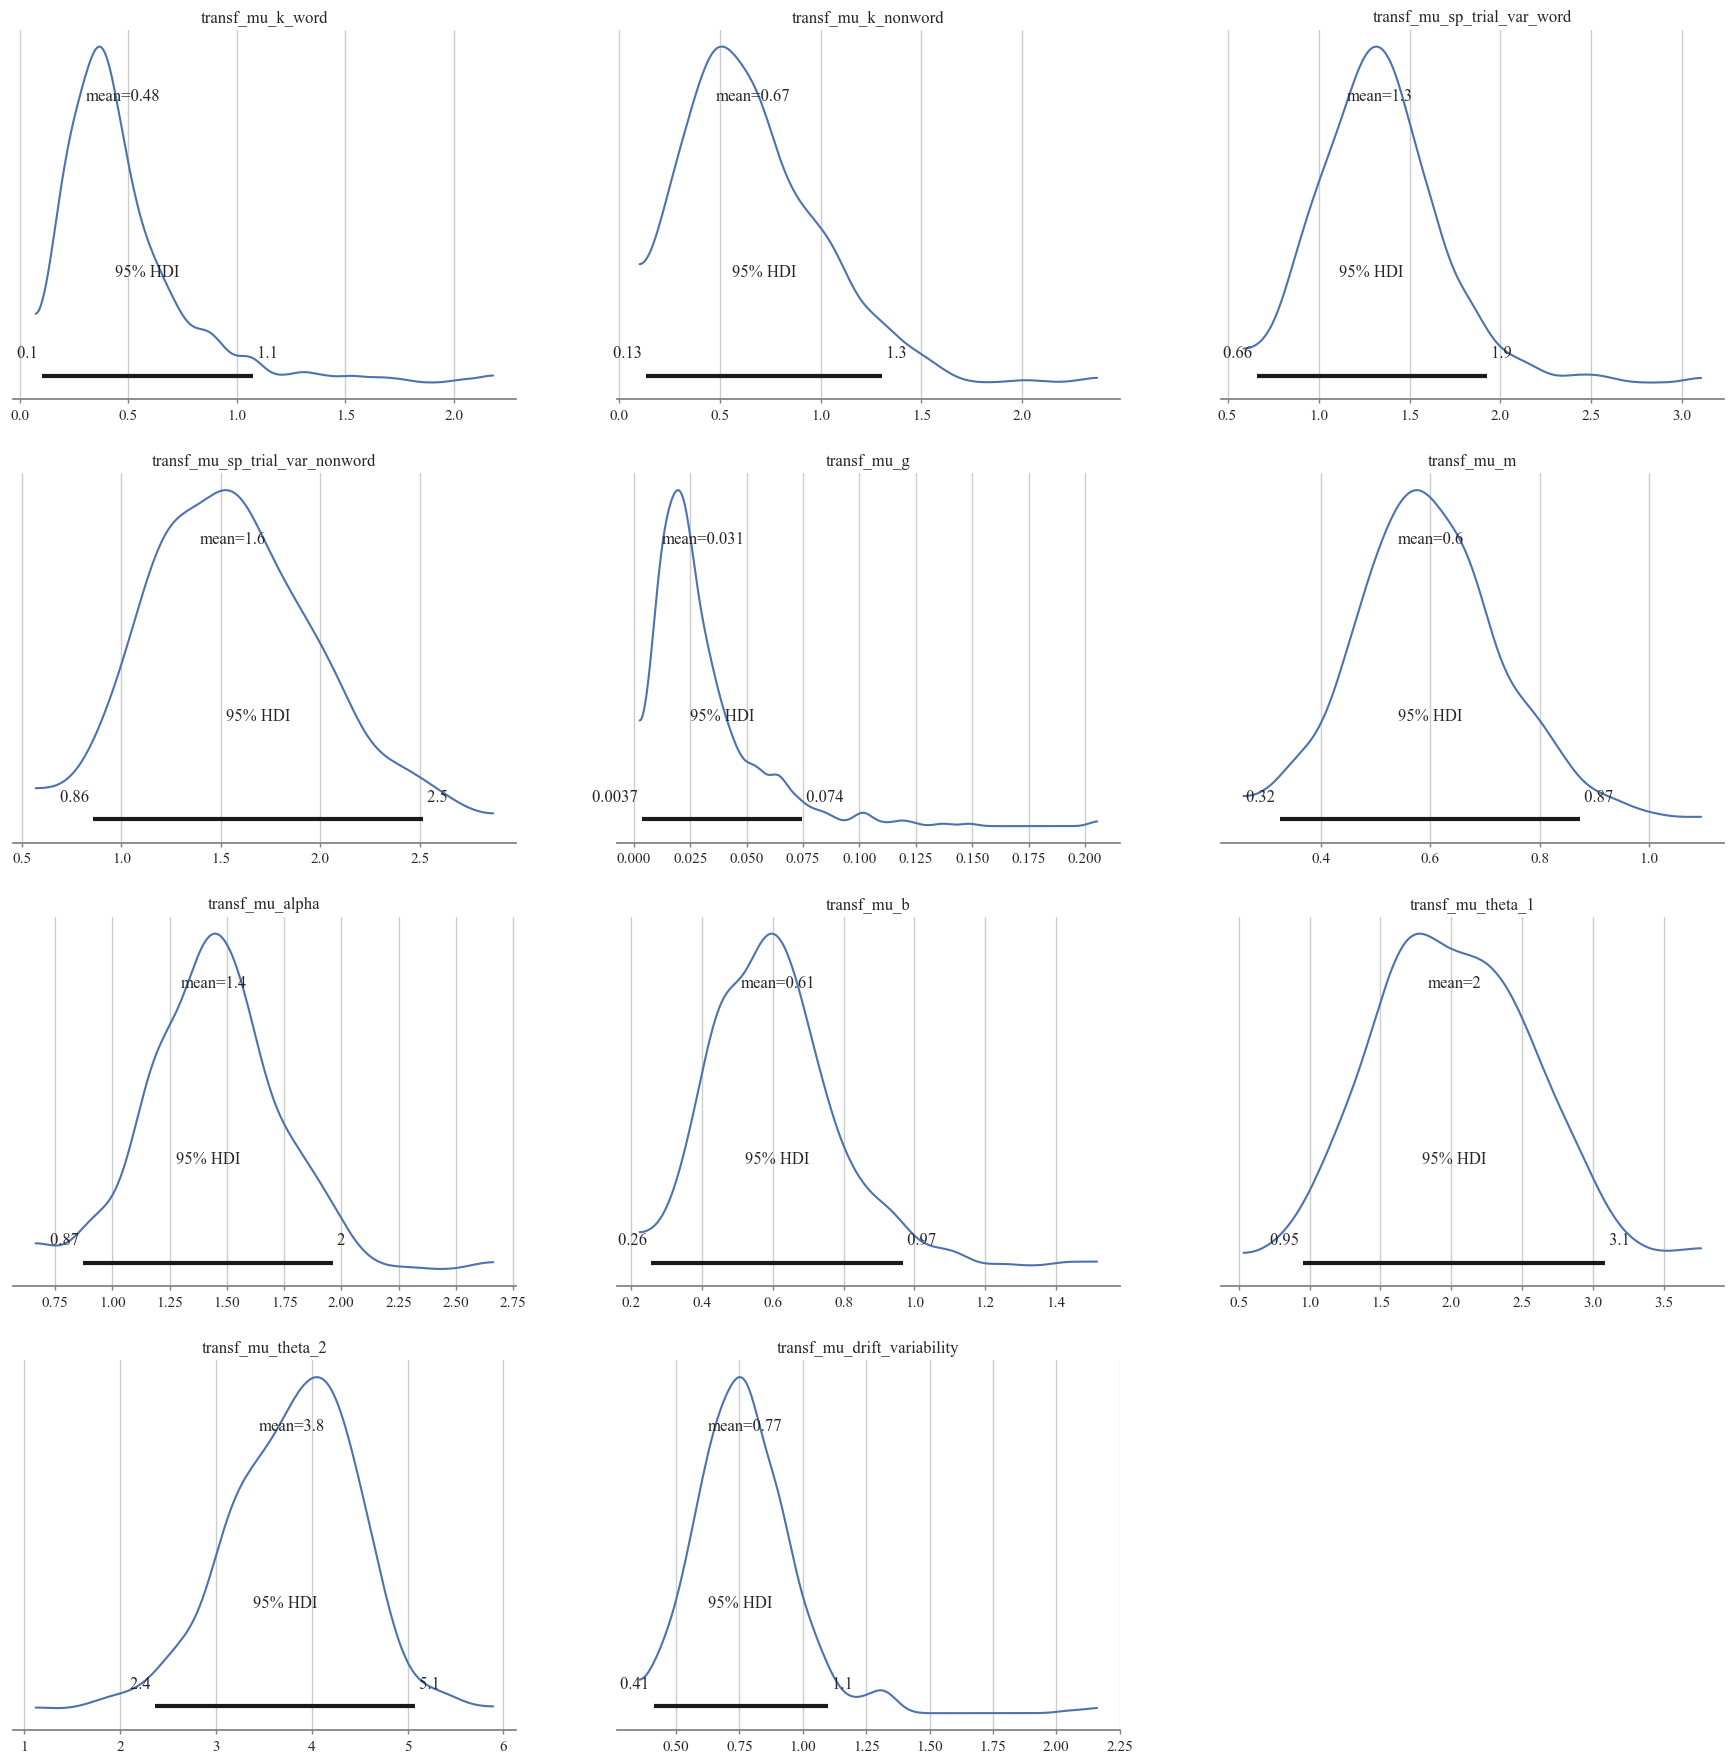

In [21]:
az.plot_posterior(fit, var_names=model_config['transf_params'],
                  hdi_prob=.95);
plt.savefig(plots_path + 'Parameters.pdf')

Loading model parameters for each trial

In [22]:
drift_word_t = fit.stan_variables()['drift_word_t']
drift_nonword_t = fit.stan_variables()['drift_nonword_t']
ndt_t = fit.stan_variables()['ndt_t']
drift_variability_t = fit.stan_variables()['drift_variability_t']
if model_config['model_name'] != "LBA":
    k_t_word = fit.stan_variables()['k_t_word']
    k_t_nonword = fit.stan_variables()['k_t_nonword']
    sp_t_word = fit.stan_variables()['sp_trial_var_t_word']
    sp_t_nonword = fit.stan_variables()['sp_trial_var_t_nonword']

else:
    k_t = fit.stan_variables()['k_t']
    sp_trial_var_t = fit.stan_variables()['sp_trial_var_t']

#### Models mean parameters in different conditions

In [23]:
v_HF_condition_w = drift_word_t[:, behavioural_df['category']=="HF"]
v_HF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="HF"]
v_LF_condition_w = drift_word_t[:, behavioural_df['category']=="LF"]
v_LF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="LF"]
v_NW_condition_w = drift_word_t[:, behavioural_df['category']=="NW"]
v_NW_condition_nw = drift_nonword_t[:, behavioural_df['category']=="NW"]

In [24]:
print('HF words, word drift mean and std:')
print(np.mean(np.mean(v_HF_condition_w, axis=1)), np.std(np.mean(v_HF_condition_w, axis=1)))
print('HF words, nonword drift mean and std:')
print(np.mean(np.mean(v_HF_condition_nw, axis=1)), np.std(np.mean(v_HF_condition_nw, axis=1)))
print('LF words word drift mean and std:')
print(np.mean(np.mean(v_LF_condition_w, axis=1)), np.std(np.mean(v_LF_condition_w, axis=1)))
print('LF words nonword drift mean and std:')
print(np.mean(np.mean(v_LF_condition_nw, axis=1)), np.std(np.mean(v_LF_condition_nw, axis=1)))
print('NW words word drift mean and std:')
print(np.mean(np.mean(v_NW_condition_w, axis=1)), np.std(np.mean(v_NW_condition_w, axis=1)))
print('NW words nonword drift mean and std:')
print(np.mean(np.mean(v_NW_condition_nw, axis=1)), np.std(np.mean(v_NW_condition_nw, axis=1)))

HF words, word drift mean and std:
2.702631165075209 0.469428687865296
HF words, nonword drift mean and std:
1.3726354805069638 0.2372103949111694
LF words word drift mean and std:
1.9690798691106557 0.34433063870064196
LF words nonword drift mean and std:
1.5695830590696724 0.26534663209587944
NW words word drift mean and std:
0.7211020346695743 0.13823870156407844
NW words nonword drift mean and std:
2.7306491271026156 0.44985722060519345


In [25]:
if model_config['model_name'] != "LBA":
    sp_HF_condition_w = sp_t_word[:, behavioural_df['category']=="HF"]
    sp_HF_condition_nw = sp_t_nonword[:, behavioural_df['category']=="HF"]
    sp_LF_condition_w = sp_t_word[:, behavioural_df['category']=="LF"]
    sp_LF_condition_nw = sp_t_nonword[:, behavioural_df['category']=="LF"]
    sp_NW_condition_w = sp_t_word[:, behavioural_df['category']=="NW"]
    sp_NW_condition_nw = sp_t_nonword[:, behavioural_df['category']=="NW"]
else:
    sp_HF_condition = sp_trial_var_t[:, behavioural_df['category']=="HF"]
    sp_LF_condition = sp_trial_var_t[:, behavioural_df['category']=="LF"]
    sp_NW_condition = sp_trial_var_t[:, behavioural_df['category']=="NW"]

In [26]:
if model_config['model_name'] != "LBA":
    print('HF words, word starting point mean and std:')
    print(np.mean(np.mean(sp_HF_condition_w, axis=1)), np.std(np.mean(sp_HF_condition_w, axis=1)))
    print('HF words, nonword starting point mean and std:')
    print(np.mean(np.mean(sp_HF_condition_nw, axis=1)), np.std(np.mean(sp_HF_condition_nw, axis=1)))
    print('LF words word starting point mean and std:')
    print(np.mean(np.mean(sp_LF_condition_w, axis=1)), np.std(np.mean(sp_LF_condition_w, axis=1)))
    print('LF words nonword starting point mean and std:')
    print(np.mean(np.mean(sp_LF_condition_nw, axis=1)), np.std(np.mean(sp_LF_condition_nw, axis=1)))
    print('NW words word starting point mean and std:')
    print(np.mean(np.mean(sp_NW_condition_w, axis=1)), np.std(np.mean(sp_NW_condition_w, axis=1)))
    print('NW words nonword starting point mean and std:')
    print(np.mean(np.mean(sp_NW_condition_nw, axis=1)), np.std(np.mean(sp_NW_condition_nw, axis=1)))
else:
    print('HF words, starting point mean and std:')
    print(np.mean(np.mean(sp_HF_condition, axis=1)), np.std(np.mean(sp_HF_condition, axis=1)))
    print('LF words starting point mean and std:')
    print(np.mean(np.mean(sp_LF_condition, axis=1)), np.std(np.mean(sp_LF_condition, axis=1)))
    print('NW words starting point mean and std:')
    print(np.mean(np.mean(sp_NW_condition, axis=1)), np.std(np.mean(sp_NW_condition, axis=1)))

HF words, word starting point mean and std:
1.3629298426518108 0.2610469781964178
HF words, nonword starting point mean and std:
1.8490996369186623 0.3306832597041599
LF words word starting point mean and std:
1.3590025366024592 0.26146419308619134
LF words nonword starting point mean and std:
1.8438258229299176 0.33060616443664714
NW words word starting point mean and std:
1.3466472497505042 0.2577930884274128
NW words nonword starting point mean and std:
1.8122534332297786 0.3259823952487696


In [27]:
if model_config['model_name'] != "LBA":
    k_HF_condition_w = k_t_word[:, behavioural_df['category']=="HF"]
    k_HF_condition_nw = k_t_nonword[:, behavioural_df['category']=="HF"]
    k_LF_condition_w = k_t_word[:, behavioural_df['category']=="LF"]
    k_LF_condition_nw = k_t_nonword[:, behavioural_df['category']=="LF"]
    k_NW_condition_w = k_t_word[:, behavioural_df['category']=="NW"]
    k_NW_condition_nw = k_t_nonword[:, behavioural_df['category']=="NW"]

    t_HF_condition_w = sp_HF_condition_w + sp_HF_condition_w
    t_HF_condition_nw = sp_HF_condition_nw + sp_HF_condition_nw
    t_LF_condition_w = sp_LF_condition_w + sp_LF_condition_w
    t_LF_condition_nw = sp_LF_condition_nw + sp_LF_condition_nw
    t_NW_condition_w = sp_NW_condition_w + sp_NW_condition_w
    t_NW_condition_nw = sp_NW_condition_nw + sp_NW_condition_nw
else:
    k_HF_condition = k_t[:, behavioural_df['category']=="HF"]
    k_LF_condition = k_t[:, behavioural_df['category']=="LF"]
    k_NW_condition = k_t[:, behavioural_df['category']=="NW"]

    t_HF_condition = sp_HF_condition + k_HF_condition
    t_LF_condition = sp_LF_condition + k_LF_condition
    t_NW_condition = sp_NW_condition + k_NW_condition

In [28]:
if model_config['model_name'] != "LBA":
    print('HF words, word threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition_w, axis=1)), np.std(np.mean(t_HF_condition_w, axis=1)))
    print('HF words, nonword threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition_nw, axis=1)), np.std(np.mean(t_HF_condition_nw, axis=1)))
    print('LF words word threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition_w, axis=1)), np.std(np.mean(t_LF_condition_w, axis=1)))
    print('LF words nonword threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition_nw, axis=1)), np.std(np.mean(t_LF_condition_nw, axis=1)))
    print('NW words word threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition_w, axis=1)), np.std(np.mean(t_NW_condition_w, axis=1)))
    print('NW words nonword threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition_nw, axis=1)), np.std(np.mean(t_NW_condition_nw, axis=1)))
else:
    print('HF words,  threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition, axis=1)), np.std(np.mean(t_HF_condition, axis=1)))
    print('LF words threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition, axis=1)), np.std(np.mean(t_LF_condition, axis=1)))
    print('NW words word threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition, axis=1)), np.std(np.mean(t_NW_condition, axis=1)))

HF words, word threshold mean and std:
2.7258596853036217 0.5220939563928356
HF words, nonword threshold mean and std:
3.6981992738373246 0.6613665194083198
LF words word threshold mean and std:
2.7180050732049184 0.5229283861723827
LF words nonword threshold mean and std:
3.687651645859835 0.6612123288732943
NW words word threshold mean and std:
2.6932944995010084 0.5155861768548256
NW words nonword threshold mean and std:
3.624506866459557 0.6519647904975392


In [29]:
if model_config['model_name'] != "LBA":
    bias_HF_condition_w = t_HF_condition_w - sp_HF_condition_w
    bias_HF_condition_nw = t_HF_condition_nw - sp_HF_condition_nw
    bias_LF_condition_w = t_LF_condition_w - sp_LF_condition_w
    bias_LF_condition_nw = t_LF_condition_nw - sp_LF_condition_nw
    bias_NW_condition_w = t_NW_condition_w - sp_NW_condition_w
    bias_NW_condition_nw = t_NW_condition_nw - sp_NW_condition_nw

In [30]:
if model_config['model_name'] != "LBA":
    print('HF words, word bias mean and std:')
    print(np.mean(np.mean(bias_HF_condition_w, axis=1)), np.std(np.mean(bias_HF_condition_w, axis=1)))
    print('HF words, nonword bias mean and std:')
    print(np.mean(np.mean(bias_HF_condition_nw, axis=1)), np.std(np.mean(bias_HF_condition_nw, axis=1)))
    print('LF words word bias mean and std:')
    print(np.mean(np.mean(bias_LF_condition_w, axis=1)), np.std(np.mean(bias_LF_condition_w, axis=1)))
    print('LF words nonword bias mean and std:')
    print(np.mean(np.mean(bias_LF_condition_nw, axis=1)), np.std(np.mean(bias_LF_condition_nw, axis=1)))
    print('NW words word bias mean and std:')
    print(np.mean(np.mean(bias_NW_condition_w, axis=1)), np.std(np.mean(bias_NW_condition_w, axis=1)))
    print('NW words nonword bias mean and std:')
    print(np.mean(np.mean(bias_NW_condition_nw, axis=1)), np.std(np.mean(bias_NW_condition_nw, axis=1)))

HF words, word bias mean and std:
1.3629298426518108 0.2610469781964178
HF words, nonword bias mean and std:
1.8490996369186623 0.3306832597041599
LF words word bias mean and std:
1.3590025366024592 0.26146419308619134
LF words nonword bias mean and std:
1.8438258229299176 0.33060616443664714
NW words word bias mean and std:
1.3466472497505042 0.2577930884274128
NW words nonword bias mean and std:
1.8122534332297786 0.3259823952487696


In [31]:
ndt_HF_condition = ndt_t[:, behavioural_df['category']=="HF"]
ndt_LF_condition = ndt_t[:, behavioural_df['category']=="LF"]
ndt_NW_condition = ndt_t[:, behavioural_df['category']=="NW"]

In [32]:
print('HF words ndt mean and std:')
print(np.mean(np.mean(ndt_HF_condition, axis=1)), np.std(np.mean(ndt_HF_condition, axis=1)))
print('LF words ndt mean and std:')
print(np.mean(np.mean(ndt_LF_condition, axis=1)), np.std(np.mean(ndt_LF_condition, axis=1)))
print('Non Words ndt mean and std:')
print(np.mean(np.mean(ndt_NW_condition, axis=1)), np.std(np.mean(ndt_NW_condition, axis=1)))

HF words ndt mean and std:
0.20406596766573817 0.01705328365227173
LF words ndt mean and std:
0.2088304959713115 0.01872524857054406
Non Words ndt mean and std:
0.21368350360160995 0.018244325733634287


## Calculating metrics

In [33]:
def calculate_waic(log_likelihood, pointwise=False):
    """
    Returns model comparisions' metrics.
    
    Parameters
    ----------
        log_likelihood: np.array
            log_likelihood of each trial
        max_rt: float
            maximum acceptable rt
        min_rt: float
             minimum acceptable rt
             
    Optional Parameters
    ----------------
    pointwise: float
        if true pointwise waic will be calculated
        
    Returns
    -------
        out:  a dictionary containing lppd, waic, waic_se and pointwise_waic    
    """
    likelihood = np.exp(log_likelihood)

    mean_l = np.mean(likelihood, axis=0) # N observations

    pointwise_lppd = np.log(mean_l)
    lppd = np.sum(pointwise_lppd)

    pointwise_var_l = np.var(log_likelihood, axis=0) # N observations
    var_l = np.sum(pointwise_var_l)

    pointwise_waic = - 2*pointwise_lppd +  2*pointwise_var_l
    waic = -2*lppd + 2*var_l
    waic_se = np.sqrt(log_likelihood.shape[1] * np.var(pointwise_waic))

    if pointwise:
        out = {'lppd':lppd,
               'p_waic':var_l,
               'waic':waic,
               'waic_se':waic_se,
               'pointwise_waic':pointwise_waic}
    else:
        out = {'lppd':lppd,
               'p_waic':var_l,
                'waic':waic,
                'waic_se':waic_se}
    return out

In [34]:
log_likelihood = fit.stan_variables()['log_lik']
print(calculate_waic(log_likelihood))

{'lppd': -720.5208275330947, 'p_waic': 41.93677336382764, 'waic': 1524.9152017938447, 'waic_se': 105.16727001467945}


## Simulating LBA with estimated parameters

In [35]:
def random_lba_2A(word_drift, nonword_drift, sp_trial_var_word, sp_trial_var_nonword,
                  ndt, k_word, k_nonword, drift_trial_var):
    """Simulates behavior (rt and accuracy) according to the Linear Ballistic Accumulator.
    Parameters
    ----------
    word_drift : numpy.ndarray
        Drift-rate of the Linear Ballistic Accumulator - correct responses. 1D array of floats.
    nonword_drift : numpy.ndarray
        Drift-rate of the Linear Ballistic Accumulator - incorrect responses. 1D array of floats.
    sp_trial_var_word : float
        Starting point variability of the Linear Ballistic Accumulator for words. Also called A.
    sp_trial_var_nonword : float
        Starting point variability of the Linear Ballistic Accumulator for non-words. Also called A.    
    ndt : float
        Non-decision time of the Linear Ballistic Accumulator. Also called tau.
    k_word : float
        Distance between starting point variability and threshold for words.
    k_nonword : float
        Distance between starting point variability and threshold for non-words.
    drift_trial_var : numpy.ndarray, default None
        The drift rate trial variability. 1D array of 0s and 1s.
    Returns
    -------
    rt : numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated response times according to the Linear Ballistic Accumulator.
        Every element corresponds to the set of parameters given as input with the same shape.
    resp: numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated response according to the Linear Ballistic Accumulator.
        Every element corresponds to the set of parameters given as input with the same shape.
    """
    shape = word_drift.shape
    resp = np.empty(shape)
    rt = np.empty(shape)
    resp[:] = np.nan
    rt[:] = np.nan

    b_word = k_word + sp_trial_var_word
    b_nonword = k_nonword + sp_trial_var_nonword
    one_pose = True
    v_word = np.array(word_drift)
    v_nonword = np.array(nonword_drift)

    # this while loop might be wrong
    while one_pose:
        ind = np.logical_and(v_word < 0, v_nonword < 0)
        if drift_trial_var is None:
            v_word[ind] = np.random.normal(word_drift[ind], np.ones(word_drift[ind].shape))
            v_nonword[ind] = np.random.normal(nonword_drift[ind], np.ones(nonword_drift[ind].shape))
        else:
            v_word[ind] = np.random.normal(word_drift[ind], drift_trial_var[ind])
            v_nonword[ind] = np.random.normal(nonword_drift[ind], drift_trial_var[ind])

        one_pose = np.sum(ind) > 0

    start_word = np.random.uniform(np.zeros(sp_trial_var_word.shape), sp_trial_var_word)
    start_non_word = np.random.uniform(np.zeros(sp_trial_var_nonword.shape), sp_trial_var_nonword)

    ttf_word = (b_word - start_word) / v_word
    ttf_nonword = (b_nonword - start_non_word) / v_nonword

    ind = np.logical_and(ttf_word <= ttf_nonword, 0 < ttf_word)
    resp[ind] = 1
    rt[ind] = ttf_word[ind] + ndt[ind]

    ind = np.logical_and(ttf_nonword < 0, 0 < ttf_word)
    resp[ind] = 1
    rt[ind] = ttf_word[ind] + ndt[ind]

    ind = np.logical_and(ttf_nonword < ttf_word, 0 < ttf_nonword)
    resp[ind] = 0
    rt[ind] = ttf_nonword[ind] + ndt[ind]

    ind = np.logical_and(ttf_word < 0, 0 < ttf_nonword)
    resp[ind] = 0
    rt[ind] = ttf_nonword[ind] + ndt[ind]

    return rt, resp

Simulating RDM with estimated parameters

In [36]:
if model_config['model_name'] != "LBA":
    pp_rt, pp_response = random_lba_2A(drift_word_t, drift_nonword_t, sp_t_word, sp_t_nonword,
                                       ndt_t, k_t_word, k_t_nonword, drift_variability_t)
else:
    pp_rt, pp_response = random_lba_2A(drift_word_t, drift_nonword_t, sp_trial_var_t, sp_trial_var_t,
                                       ndt_t, k_t, k_t, drift_variability_t)

In [37]:
def bci(x, alpha=0.05):
    """
    Calculate Bayesian credible interval (BCI).
    
    Parameters
    ----------
    x : array-like
        An array containing MCMC samples.
    
    Optional Parameters
    -------------------
    alpha : float, default 0.05
        Desired probability of type I error.
    
    Returns
    -------
    interval : numpy.ndarray
        Array containing the lower and upper bounds of the bci interval.
    """
    interval = np.nanpercentile(x, [(alpha/2)*100, (1-alpha/2)*100])

    return interval

In [38]:
# Predicted Data
rt_predictions = pd.concat((pd.DataFrame(pp_rt, index=pd.Index(np.arange(1, len(pp_rt)+1))).T, behavioural_df['category']), axis=1)
response_predictions = pd.concat((pd.DataFrame(pp_response, index=pd.Index(np.arange(1, len(pp_response)+1))).T, behavioural_df['category']), axis=1)

# Experiment Data
experiment_data = behavioural_df.loc[:, ['rt', 'response', 'category']]

Separating RT and Response of predicted and experimental data for each condition

In [39]:
HF_data = experiment_data.loc[experiment_data['category']=='HF']
LF_data = experiment_data.loc[experiment_data['category']=='LF']
NW_data = experiment_data.loc[experiment_data['category']=='NW']

HF_pred_rt = rt_predictions.loc[rt_predictions['category']=='HF'].drop(['category'], axis=1)
HF_pred_resp = response_predictions.loc[response_predictions['category']=='HF'].drop(['category'], axis=1)
LF_pred_rt = rt_predictions.loc[rt_predictions['category']=='LF'].drop(['category'], axis=1)
LF_pred_resp = response_predictions.loc[response_predictions['category']=='LF'].drop(['category'], axis=1)
NW_pred_rt = rt_predictions.loc[rt_predictions['category']=='NW'].drop(['category'], axis=1)
NW_pred_resp = response_predictions.loc[response_predictions['category']=='NW'].drop(['category'], axis=1)

## Quantiles Posterior Predictions

In [40]:
quantiles = [.1, .3, .5, .7, .9]
percentiles = np.array(quantiles)*100

In [41]:
# experiment Data quantile
HF_quantile_ex = HF_data['rt'].quantile(quantiles)
LF_quantile_ex = LF_data['rt'].quantile(quantiles)
NW_quantile_ex = NW_data['rt'].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_quantile_pred = HF_pred_rt.quantile(quantiles, axis=0).T
LF_quantile_pred = LF_pred_rt.quantile(quantiles, axis=0).T
NW_quantile_pred = NW_pred_rt.quantile(quantiles, axis=0).T

# predicted data quantiles bci
HF_predicted_bci = np.array([bci(HF_quantile_pred[x]) for x in quantiles])
LF_predicted_bci = np.array([bci(LF_quantile_pred[x]) for x in quantiles])
NW_predicted_bci = np.array([bci(NW_quantile_pred[x]) for x in quantiles])

C:\Users\Arash\AppData\Local\Temp\ipykernel_9440\1342134211.py:34: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(16)
C:\Users\Arash\AppData\Local\Temp\ipykernel_9440\1342134211.py:36: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(16)


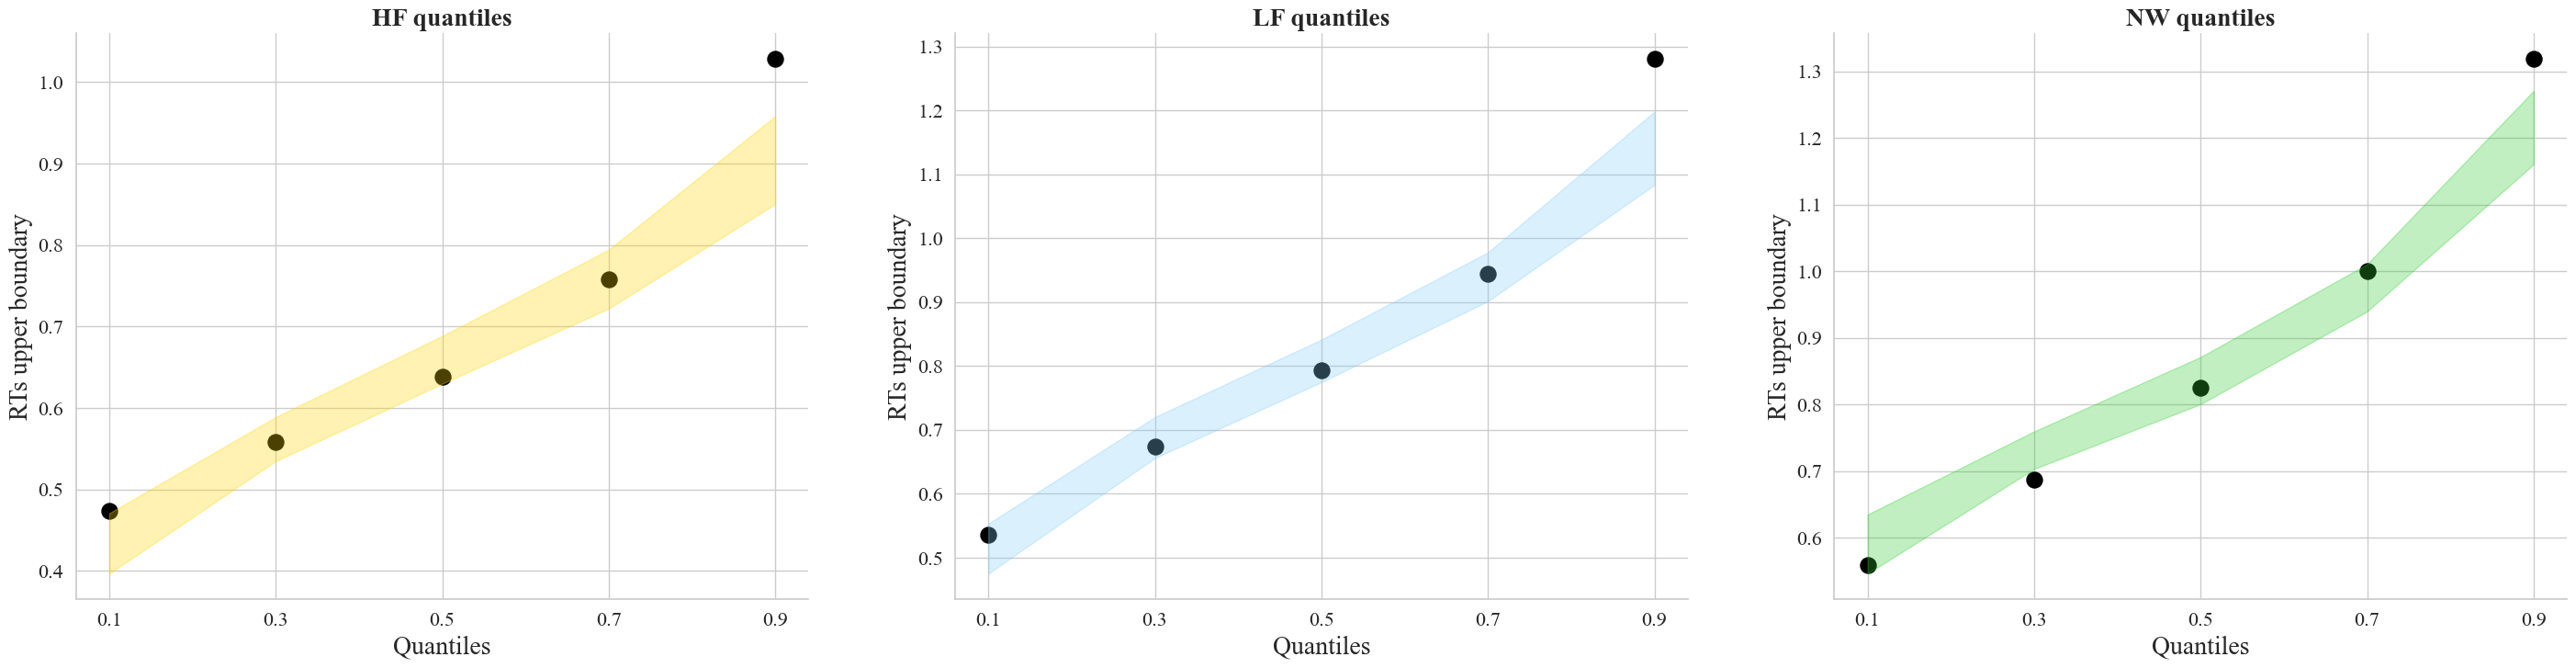

In [42]:
fig, axes = plt.subplots(1,3 , figsize=(35,8))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title('HF quantiles', fontweight="bold", size=20)
axes[1].set_title('LF quantiles', fontweight="bold", size=20)
axes[2].set_title('NW quantiles', fontweight="bold", size=20)

axes[0].scatter(quantiles, HF_quantile_ex, color='black', s=150)
axes[1].scatter(quantiles, LF_quantile_ex, color='black', s=150)
axes[2].scatter(quantiles, NW_quantile_ex, color='black', s=150)

axes[0].fill_between(quantiles,
                HF_predicted_bci[:, 0],
                HF_predicted_bci[:, 1],
                HF_predicted_bci[:, 0] < HF_predicted_bci[:, 1],  color = 'gold', alpha=0.3)

axes[1].fill_between(quantiles,
                LF_predicted_bci[:, 0],
                LF_predicted_bci[:, 1],
                LF_predicted_bci[:, 0] < LF_predicted_bci[:, 1],  color = 'lightskyblue', alpha=0.3)

axes[2].fill_between(quantiles,
                NW_predicted_bci[:, 0],
                NW_predicted_bci[:, 1],
                NW_predicted_bci[:, 0] < NW_predicted_bci[:, 1],  color = 'limegreen', alpha=0.3)


for ax in axes:
        ax.set_xlabel('Quantiles', fontsize=20)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary', fontsize=20)
        for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(16)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(16) 

sns.despine()
plt.savefig(plots_path + 'Quantiles Poseterior.pdf')

## Mean Accuracy and RT Posterior Plots

In [43]:
HF_data_rt_mean = HF_data['rt'].mean()
LF_data_rt_mean = LF_data['rt'].mean()
NW_data_rt_mean = NW_data['rt'].mean()

HF_pred_rt_mean = HF_pred_rt.mean(axis=0)
LF_pred_rt_mean = LF_pred_rt.mean(axis=0)
NW_pred_rt_mean = NW_pred_rt.mean(axis=0)


HF_data_resp_mean = HF_data['response'].mean()
LF_data_resp_mean = LF_data['response'].mean()
NW_data_resp_mean = NW_data['response'].mean()

HF_pred_resp_mean = HF_pred_resp.mean(axis=0)
LF_pred_resp_mean = LF_pred_resp.mean(axis=0)
NW_pred_resp_mean = NW_pred_resp.mean(axis=0)


In [44]:
def plot_posterior(x, data_mean, ax):
    """
    Plots the posterior of x with experimental data mean as a line
    
    Parameters
    ----------
    x : array-like
        An array containing RT or response for each trial.
        
    x : float
        mean of RT or Accuracy of experimental data.

    ax : matplotlib.axes.Axes
        
    Returns
    -------
    None
    """
    density = gaussian_kde(x, bw_method='scott')
    xd = np.linspace(x.min(), x.max())
    yd = density(xd)

    low, high = bci(x)
    ax.fill_between(xd[np.logical_and(xd >= low, xd <= high)],
                     yd[np.logical_and(xd >= low, xd <= high)], color = 'lightsteelblue')

    ax.plot(xd, yd, color='slategray')
    ax.axvline(data_mean, color='red')

C:\Users\Arash\AppData\Local\Temp\ipykernel_9440\102435654.py:26: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(13)
C:\Users\Arash\AppData\Local\Temp\ipykernel_9440\102435654.py:28: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(13)
C:\Users\Arash\AppData\Local\Temp\ipykernel_9440\102435654.py:30: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(13)
C:\Users\Arash\AppData\Local\Temp\ipykernel_9440\102435654.py:32: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(13)


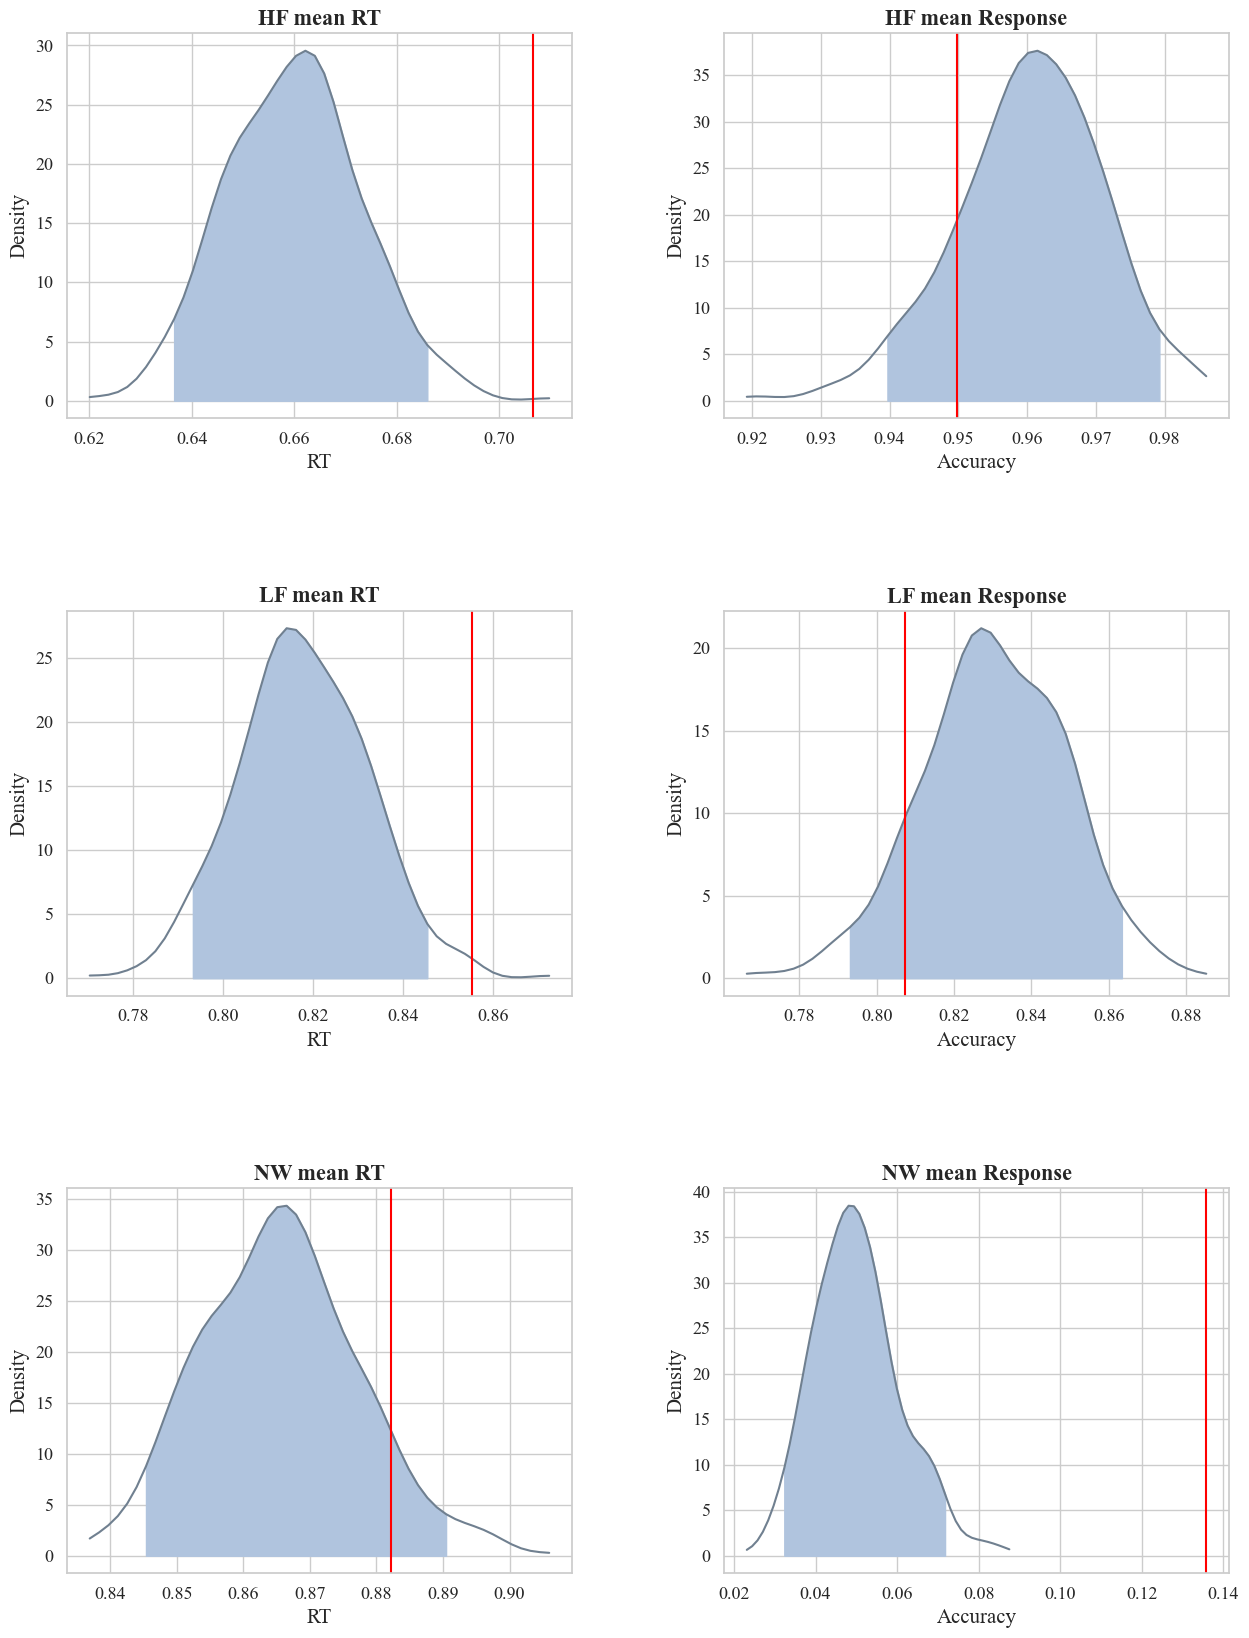

In [45]:
fig, axes = plt.subplots(3,2 , figsize=(15,20))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title('HF mean RT', fontweight="bold", size=16)
axes[0][1].set_title('HF mean Response', fontweight="bold", size=16)
axes[1][0].set_title('LF mean RT', fontweight="bold", size=16)
axes[1][1].set_title('LF mean Response', fontweight="bold", size=16)
axes[2][0].set_title('NW mean RT', fontweight="bold", size=16)
axes[2][1].set_title('NW mean Response', fontweight="bold", size=16)

plot_posterior(HF_pred_rt_mean, HF_data_rt_mean, axes[0][0])
plot_posterior(HF_pred_resp_mean, HF_data_resp_mean, axes[0][1])

plot_posterior(LF_pred_rt_mean, LF_data_rt_mean, axes[1][0])
plot_posterior(LF_pred_resp_mean, LF_data_resp_mean, axes[1][1])

plot_posterior(NW_pred_rt_mean, NW_data_rt_mean, axes[2][0])
plot_posterior(NW_pred_resp_mean, NW_data_resp_mean, axes[2][1])

for ax in axes:
        ax[0].set_xlabel('RT', fontsize=15)
        ax[1].set_xlabel('Accuracy', fontsize=15)
        ax[0].set_ylabel('Density', fontsize=15)
        ax[1].set_ylabel('Density', fontsize=15)
        for tick in ax[0].xaxis.get_major_ticks():
                tick.label.set_fontsize(13)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label.set_fontsize(13)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label.set_fontsize(13)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label.set_fontsize(13) 

plt.savefig(plots_path + 'Mean Accuracy and RT.pdf')